# COCO DATASET GATHERING

In [0]:
!wget http://images.cocodataset.org/zips/train2014.zip
!unzip -q train2014.zip
!wget http://images.cocodataset.org/zips/val2014.zip
!wget http://images.cocodataset.org/annotations/annotations_trainval2014.zip
!unzip -q val2014.zip
!unzip -q annotations_trainval2014.zip


! pip install 2to3
!git clone https://github.com/cocodataset/cocoapi.git
%cd cocoapi
!2to3 . -w
%cd PythonAPI
!python3 setup.py install


In [0]:
%cd /content/

In [0]:
# Importing Data From COCO

from pycocotools import coco, cocoeval, _mask
from pycocotools import mask as maskUtils 
import array
import numpy as np
import skimage.io as io
import matplotlib.pyplot as plt
import pylab
import os
pylab.rcParams['figure.figsize'] = (8.0, 10.0)
%matplotlib inline


In [0]:
CATEGORY_NAMES=['person']

ANNOTATION_FILE_VAL = '/content/annotations/instances_val2014.json'
ANNOTATION_FILE_TRAIN = '/content/annotations/instances_train2014.json'


coco_train = coco.COCO(ANNOTATION_FILE_TRAIN)
catIds_train = coco_train.getCatIds(catNms=CATEGORY_NAMES);
imgIds_train = coco_train.getImgIds(catIds=catIds_train);
imgDict_train = coco_train.loadImgs(imgIds_train)
len(imgIds_train) , len(catIds_train)





coco_val = coco.COCO(ANNOTATION_FILE_VAL)
catIds_val = coco_val.getCatIds(catNms=CATEGORY_NAMES);
imgIds_val = coco_val.getImgIds(catIds=catIds_val);
imgDict_val = coco_val.loadImgs(imgIds_val)
len(imgIds_val) , len(catIds_val)

In [0]:
from random import shuffle


shuffle(imgIds_train)
shuffle(imgIds_val)

imgIds_train = imgIds_train[0:6000]
imgIds_val = imgIds_val[0:600]


In [0]:
train_images_person = ["COCO_train2014_{0:012d}.jpg".format(ids) for ids in imgIds_train]
val_images_person = ["COCO_val2014_{0:012d}.jpg".format(ids) for ids in imgIds_val]

In [0]:
print(len(train_images_person) , len(val_images_person))

In [0]:
train_images_person = ["COCO_train2014_{0:012d}.jpg".format(ids) for ids in imgIds_train]
print(train_images_person)
del_img_train = set(os.listdir("/content/train2014")) - set(train_images_person)
for file_name in del_img_train:
  file_name = "/content/train2014/" + file_name
  if os.path.exists(file_name):
    os.remove(file_name)



In [0]:
print(len(os.listdir("/content/train2014")))

In [0]:
val_images_person = ["COCO_val2014_{0:012d}.jpg".format(ids) for ids in imgIds_val]
print(val_images_person)
del_img_val = set(os.listdir("/content/val2014")) - set(val_images_person)
for file_name in del_img_val:
  file_name = "/content/val2014/" + file_name
  if os.path.exists(file_name):
    os.remove(file_name)

len(os.listdir("/content/val2014"))

In [0]:
from PIL import Image


In [0]:
!mkdir mask_train_2014

In [0]:
count = 0 

for ID in imgIds_train:

  file_path = "/content/mask_train_2014/COCO_train2014_{0:012d}.jpg".format(ID)
  
  sampleImgIds = coco_train.getImgIds(imgIds = [ID])
  sampleImgDict = coco_train.loadImgs(sampleImgIds[np.random.randint(0,len(sampleImgIds))])[0]

  annIds = coco_train.getAnnIds(imgIds=sampleImgDict['id'], catIds=catIds_train, iscrowd=0)
  anns = coco_train.loadAnns(annIds)


  mask = coco_train.annToMask(anns[0])
  for i in range(len(anns)):
      mask = mask | coco_train.annToMask(anns[i])
  
  mask = Image.fromarray(mask * 255 , mode = "L")
  mask.save(file_path)
  count = count + 1
  print(count)

In [0]:
!mkdir mask_val_2014

In [0]:
count = 0 
for ID in imgIds_val:

  file_path = "/content/mask_val_2014/COCO_val2014_{0:012d}.jpg".format(ID)
  
  sampleImgIds = coco_val.getImgIds(imgIds = [ID])
  sampleImgDict = coco_val.loadImgs(sampleImgIds[np.random.randint(0,len(sampleImgIds))])[0]

  annIds = coco_val.getAnnIds(imgIds=sampleImgDict['id'], catIds=catIds_val, iscrowd=0)
  anns = coco_val.loadAnns(annIds)


  mask = coco_val.annToMask(anns[0])
  for i in range(len(anns)):
      mask = mask | coco_val.annToMask(anns[i])
  
  mask = Image.fromarray(mask * 255 , mode = "L")
  mask.save(file_path)
  
  count = count + 1
  print(count)

In [0]:
!rm -rf annotations/
!rm -rf train2014.zip
!rm -rf val2014.zip
!rm -rf annotations_trainval2014.zip

# Data Generator

In [0]:
import os
import sys
import random

import numpy as np
import cv2
import tensorflow as tf
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
from tensorflow.keras.optimizers import *


seed = 2019

random.seed = seed
np.random.seed = seed 

In [0]:
class DataGen(tf.keras.utils.Sequence):
  
  def __init__(self , path_input , path_mask , batch_size = 8 , image_size = 128):
    
    self.ids = os.listdir(path_input)
    self.path_input = path_input
    self.path_mask = path_mask
    self.batch_size = batch_size
    self.image_size = image_size
    self.on_epoch_end()
  
  def __load__(self , id_name):
    
    image_path = os.path.join(self.path_input , id_name)
    mask_path = os.path.join(self.path_mask , id_name) 
    
    image = cv2.imread(image_path , 1) # 1 specifies RGB format
    image = cv2.resize(image , (self.image_size , self.image_size)) # resizing before inserting to the network
    
    mask = cv2.imread(mask_path , -1)
    mask = cv2.resize(mask , (self.image_size , self.image_size))
    mask = mask.reshape((self.image_size , self.image_size , 1))
      
    #normalize image
    image = image / 255.0
    mask = mask / 255.0
    
    return image , mask
  
  def __getitem__(self , index):
    
    if (index + 1)*self.batch_size > len(self.ids):
      self.batch_size = len(self.ids) - index * self.batch_size
        
    file_batch = self.ids[index * self.batch_size : (index + 1) * self.batch_size]
    
    images = []
    masks = []
    
    for id_name in file_batch : 
      
      _img , _mask = self.__load__(id_name)
      images.append(_img)
      masks.append(_mask)
    
    
    images = np.array(images)
    masks = np.array(masks)
    
    
    return images , masks
  
  
  def on_epoch_end(self):
    pass
  
  
  def __len__(self):
    
    return int(np.ceil(len(self.ids) / float(self.batch_size)))

#UNet

In [0]:
def down_block(
    input_tensor,
    no_filters,
    kernel_size=(3, 3),
    strides=(1, 1),
    padding="same",
    kernel_initializer="he_normal",
    max_pool_window=(2, 2),
    max_pool_stride=(2, 2)
):
    conv = Conv2D(
        filters=no_filters,
        kernel_size=kernel_size,
        strides=strides,
        activation=None,
        padding=padding,
        kernel_initializer=kernel_initializer
    )(input_tensor)

    conv = BatchNormalization(scale=True)(conv)

    conv = Activation("relu")(conv)

    conv = Conv2D(
        filters=no_filters,
        kernel_size=kernel_size,
        strides=strides,
        activation=None,
        padding=padding,
        kernel_initializer=kernel_initializer
    )(conv)

    conv = BatchNormalization(scale=True)(conv)

    # conv for skip connection
    conv = Activation("relu")(conv)

    pool = MaxPooling2D(pool_size=max_pool_window, strides=max_pool_stride)(conv)

    return conv, pool

In [0]:
def bottle_neck(
    input_tensor,
    no_filters,
    kernel_size=(3, 3),
    strides=(1, 1),
    padding="same",
    kernel_initializer="he_normal"
):
    conv = Conv2D(
        filters=no_filters,
        kernel_size=kernel_size,
        strides=strides,
        activation=None,
        padding=padding,
        kernel_initializer=kernel_initializer
    )(input_tensor)

    conv = BatchNormalization(scale=True)(conv)

    conv = Activation("relu")(conv)

    conv = Conv2D(
        filters=no_filters,
        kernel_size=kernel_size,
        strides=strides,
        activation=None,
        padding=padding,
        kernel_initializer=kernel_initializer
    )(conv)

    conv = BatchNormalization(scale=True)(conv)

    conv = Activation("relu")(conv)

    return conv

In [0]:
def up_block(    
    input_tensor,
    no_filters,
    skip_connection, 
    kernel_size=(3, 3),
    strides=(1, 1),
    upsampling_factor = (2,2),
    max_pool_window = (2,2),
    padding="same",
    kernel_initializer="he_normal"):
    
    
    conv = Conv2D(
        filters = no_filters,
        kernel_size= max_pool_window,
        strides = strides,
        activation = None,
        padding = padding,
        kernel_initializer=kernel_initializer
    )(UpSampling2D(size = upsampling_factor)(input_tensor))
    
    conv = BatchNormalization(scale=True)(conv)

    conv = Activation("relu")(conv) 
    
    
    conv = concatenate( [skip_connection , conv]  , axis = -1)
    
    
    conv = Conv2D(
        filters=no_filters,
        kernel_size=kernel_size,
        strides=strides,
        activation=None,
        padding=padding,
        kernel_initializer=kernel_initializer
    )(conv)

    conv = BatchNormalization(scale=True)(conv)

    conv = Activation("relu")(conv)

    conv = Conv2D(
        filters=no_filters,
        kernel_size=kernel_size,
        strides=strides,
        activation=None,
        padding=padding,
        kernel_initializer=kernel_initializer
    )(conv)

    conv = BatchNormalization(scale=True)(conv)

    conv = Activation("relu")(conv)
    
    return conv



In [0]:
def output_block(input_tensor,
    padding="same",
    kernel_initializer="he_normal"
):
    
    conv = Conv2D(
        filters=2,
        kernel_size=(3,3),
        strides=(1,1),
        activation="relu",
        padding=padding,
        kernel_initializer=kernel_initializer
    )(input_tensor)
    
    
    conv = Conv2D(
        filters=1,
        kernel_size=(1,1),
        strides=(1,1),
        activation="sigmoid",
        padding=padding,
        kernel_initializer=kernel_initializer
    )(conv)
    
    
    return conv
    

In [0]:
def UNet(input_shape = (128,128,3)):
    
    filter_size = [64,128,256,512,1024]
    
    inputs = Input(shape = input_shape)
    
    d1 , p1 = down_block(input_tensor= inputs,
                         no_filters=filter_size[0],
                         kernel_size = (3,3),
                         strides=(1,1),
                         padding="same",
                         kernel_initializer="he_normal",
                         max_pool_window=(2,2),
                         max_pool_stride=(2,2))
    
    
    d2 , p2 = down_block(input_tensor= p1,
                         no_filters=filter_size[1],
                         kernel_size = (3,3),
                         strides=(1,1),
                         padding="same",
                         kernel_initializer="he_normal",
                         max_pool_window=(2,2),
                         max_pool_stride=(2,2))
    
    
    
    d3 , p3 = down_block(input_tensor= p2,
                         no_filters=filter_size[2],
                         kernel_size = (3,3),
                         strides=(1,1),
                         padding="same",
                         kernel_initializer="he_normal",
                         max_pool_window=(2,2),
                         max_pool_stride=(2,2))
    
    
    
    d4 , p4 = down_block(input_tensor= p3,
                         no_filters=filter_size[3],
                         kernel_size = (3,3),
                         strides=(1,1),
                         padding="same",
                         kernel_initializer="he_normal",
                         max_pool_window=(2,2),
                         max_pool_stride=(2,2))
    
    
    b = bottle_neck(input_tensor= p4,
                         no_filters=filter_size[4],
                         kernel_size = (3,3),
                         strides=(1,1),
                         padding="same",
                         kernel_initializer="he_normal")
    
    
    
    u4 = up_block(input_tensor = b,
                  no_filters = filter_size[3],
                  skip_connection = d4,
                  kernel_size=(3, 3),
                  strides=(1, 1),
                  upsampling_factor = (2,2),
                  max_pool_window = (2,2),
                  padding="same",
                  kernel_initializer="he_normal")
    
    u3 = up_block(input_tensor = u4,
                  no_filters = filter_size[2],
                  skip_connection = d3,
                  kernel_size=(3, 3),
                  strides=(1, 1),
                  upsampling_factor = (2,2),
                  max_pool_window = (2,2),
                  padding="same",
                  kernel_initializer="he_normal")
    
    
    u2 = up_block(input_tensor = u3,
                  no_filters = filter_size[1],
                  skip_connection = d2,
                  kernel_size=(3, 3),
                  strides=(1, 1),
                  upsampling_factor = (2,2),
                  max_pool_window = (2,2),
                  padding="same",
                  kernel_initializer="he_normal")
    
    
    u1 = up_block(input_tensor = u2,
                  no_filters = filter_size[0],
                  skip_connection = d1,
                  kernel_size=(3, 3),
                  strides=(1, 1),
                  upsampling_factor = (2,2),
                  max_pool_window = (2,2),
                  padding="same",
                  kernel_initializer="he_normal")
    
    
    
    output = output_block(input_tensor=u1 , 
                         padding = "same",
                         kernel_initializer= "he_normal")
    
    model = Model(inputs = inputs , outputs = output)
    
    
    return model
    

In [0]:
model = UNet(input_shape = (128,128,3))
model.compile(optimizer = Adam(lr = 1e-4), loss = 'binary_crossentropy', metrics = ['accuracy'])

In [0]:
image_size = 128 
epochs = 10
batch_size = 8


In [0]:
train_gen = DataGen(path_input = "/content/train2014" , path_mask = "/content/mask_train_2014/" , batch_size = batch_size , image_size = image_size)
val_gen = DataGen(path_input =  "/content/val2014", path_mask =  "/content/mask_val_2014", batch_size = batch_size , image_size = image_size)


train_steps =  len(os.listdir( "/content/train2014"))/batch_size


model.fit_generator(train_gen , validation_data = val_gen , steps_per_epoch = train_steps , epochs=epochs)

Epoch 1/10
750/750 [==============================] - 344s 458ms/step - loss: 0.6813 - acc: 0.8204 - val_loss: 0.6685 - val_acc: 0.8300
Epoch 2/10
750/750 [==============================] - 335s 447ms/step - loss: 0.6576 - acc: 0.8230 - val_loss: 0.6456 - val_acc: 0.8302
Epoch 3/10
750/750 [==============================] - 336s 447ms/step - loss: 0.6352 - acc: 0.8254 - val_loss: 0.6708 - val_acc: 0.6962
Epoch 4/10
750/750 [==============================] - 336s 447ms/step - loss: 0.6093 - acc: 0.8384 - val_loss: 0.6203 - val_acc: 0.8332
Epoch 5/10
750/750 [==============================] - 335s 447ms/step - loss: 0.5830 - acc: 0.8499 - val_loss: 0.5680 - val_acc: 0.8603
Epoch 6/10
750/750 [==============================] - 335s 447ms/step - loss: 0.5579 - acc: 0.8583 - val_loss: 0.5567 - val_acc: 0.8549
Epoch 7/10
750/750 [==============================] - 336s 447ms/step - loss: 0.5340 - acc: 0.8650 - val_loss: 0.5211 - val_acc: 0.8713
Epoch 8/10
750/750 [============================

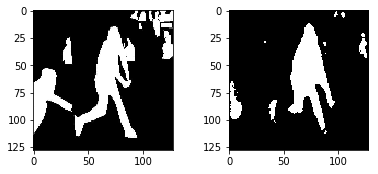

In [0]:
x, y = val_gen.__getitem__(4)
result = model.predict(x)

result = result > 0.5



fig = plt.figure()
fig.subplots_adjust(hspace=0.4, wspace=0.4)

ax = fig.add_subplot(1, 2, 1)
ax.imshow(np.reshape(y[0]*255, (image_size, image_size)), cmap="gray")

ax = fig.add_subplot(1, 2, 2)
ax.imshow(np.reshape(result[0]*255, (image_size, image_size)), cmap="gray")